NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 134 288 5 28 

accuracy, precision, recall, F1Score= 0.9274725274725275 0.9640287769784173 0.8271604938271605 0.8903654485049833 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 43 64 0 7 

accuracy, precision, recall, F1Score= 0.9385964912280702 1.0 0.86 0.9247311827956989 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 138 291 2 24 

accuracy, precision, recall, F1Score= 0.9428571428571428 0.9857142857142858 0.8518518518518519 0.9139072847682119 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 43 64 0 7 

accuracy, precision, recall, F1Score= 0.9385964912280702 1.0 0.86 0.9247311827956989 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 141 292 1 21 

accuracy, precision, recall, F1Score= 0.9516483516483516 0.9929577464788732 0.8703703703703703 0.9276315789473685 

NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg 43 64 0 7 

accuracy, precision, recall, F1Score= 0.9385964912280702 1.0 0.86 0.9247311827956989 

NbTruePos + NbTrueNeg 

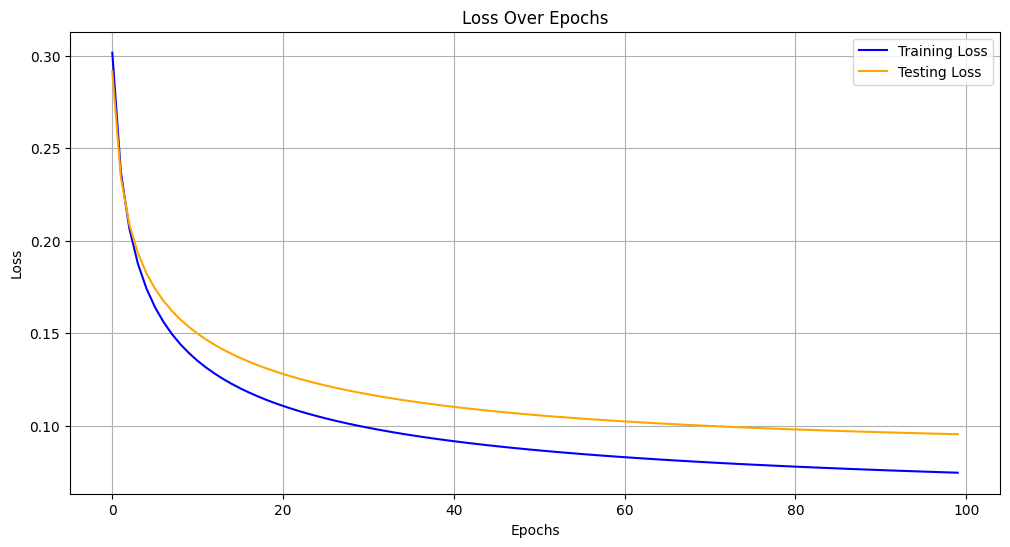

accuracy_test= 0.9736842105263158
precision_test= 1.0
recall_test= 0.94
f1score_test= 0.9690721649484536


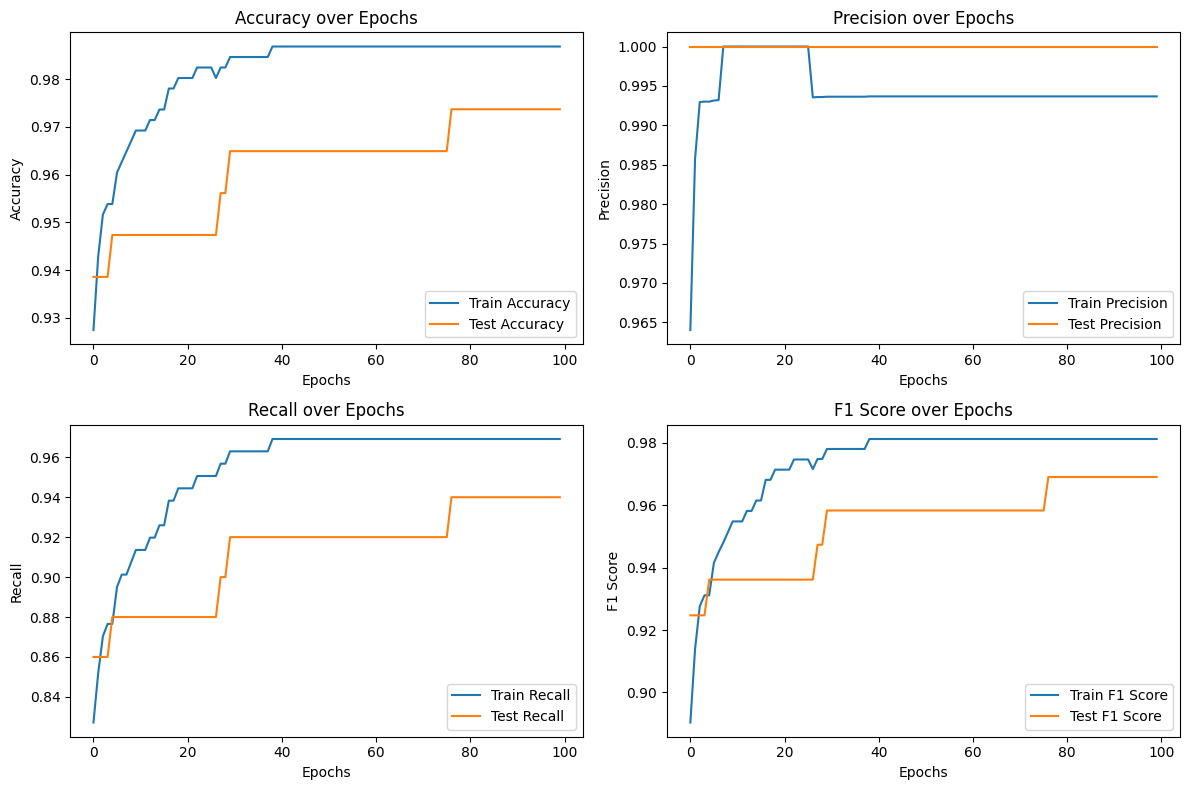

AUC: 0.993500125


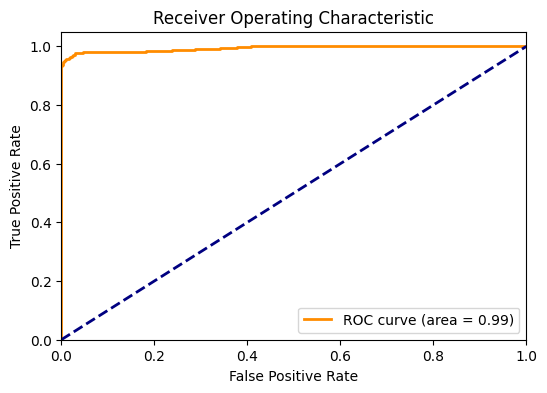

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

# Load data from CSV
data = pd.read_csv("/content/sample_data/wdbc.csv")

# Convert 'M' to 1 and 'B' to 0
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0}).astype(int)

# Extract the necessary columns
columns = ['ID','Diagnosis','radius1','texture1','perimeter1','area1','smoothness1','compactness1','concavity1','concave_points1','symmetry1',
'fractal_dimension1','radius2','texture2','perimeter2','area2','smoothness2','compactness2','concavity2','concave_points2','symmetry2','fractal_dimension2',
'radius3','texture3','perimeter3','area3','smoothness3','compactness3','concavity3','concave_points3','symmetry3','fractal_dimension3']
data_m = data[columns].to_numpy()

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of sigmoid for backpropagation
def sigmoid_derivative(x):
    return x * (1 - x)

# Binary cross-entropy loss function
def binary_cross_entropy(y_true, y_pred):
    # Clip y_pred to avoid log(0) which is undefined
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Process data with median and normalization
def process_data_median(col):
    non_zero_values = data_m[data_m[:, col] != 0, col]
    median_value = np.median(non_zero_values)
    data_m[data_m[:, col] == 0, col] = median_value

def normalise(col):
    norm_col1 = data_m[:, col]
    min_v, max_v = np.min(norm_col1), np.max(norm_col1)
    data_m[:, col] = (norm_col1 - min_v) / (max_v - min_v)

# Applying processing and normalization based on the column flags
for i in range(30):
    process_data_median(i+2)
    normalise(i+2)

nb_param = 32

# Use train_test_split to split the data into training and testing sets
X_train, X_test = train_test_split(data_m, test_size=0.2)

# Set the training and testing rows
rows_tr = X_train.shape[0]

# Initialize theta for the perceptron
theta = np.array([0.5] * (nb_param - 1) + [1.0])

# Lists to store metrics for plotting for the perceptron
accuracy_train, precision_train, recall_train, f1score_train = [], [], [], []
accuracy_test, precision_test, recall_test, f1score_test = [], [], [], []
y_true_test, y_scores_test = [], []
loss_train, loss_test = [], []  # Lists to store the loss values

# Perceptron training function
def perceptron(lr, nbp, epochs, theta1):
    for epoch in range(epochs):
        for i in range(rows_tr):
            # Compute the product of all Xi (from i=2 to n)
            Prod = np.prod(X_train[i, 2:].astype(np.float64))

            # Output layer (single perceptron output)
            output_layer = sigmoid(np.dot(X_train[i, 2:].astype(np.float64), theta1[:nbp-2]) + theta1[nbp-2] * Prod + theta1[nbp-1])

            # Calculate the error, X_train[i, 1] is the ground truth
            error = X_train[i, 1] - output_layer
            d_output = error * sigmoid_derivative(output_layer)

            # Update the weights theta
            theta[:nbp-2] += lr * d_output * X_train[i, 2:].astype(np.float64)
            theta[nbp-2] += lr * d_output * Prod
            theta[nbp-1] += lr * d_output

        # Evaluate and store metrics after each epoch
        train_metrics = evaluate(0, rows_tr, X_train, theta)
        accuracy_train.append(train_metrics[0])
        precision_train.append(train_metrics[1])
        recall_train.append(train_metrics[2])
        f1score_train.append(train_metrics[3])

        test_metrics = evaluate(0, X_test.shape[0], X_test, theta1)
        accuracy_test.append(test_metrics[0])
        precision_test.append(test_metrics[1])
        recall_test.append(test_metrics[2])
        f1score_test.append(test_metrics[3])

        # Store true labels and predicted scores for the ROC curve
        y_true_test.extend(X_test[:, 1])
        y_scores_test.extend(calculate_scores(0, X_test.shape[0], X_test, theta))

        # Compute and store the loss for both training and testing sets
        loss_train.append(binary_cross_entropy(X_train[:, 1], calculate_scores(0, rows_tr, X_train, theta)))
        loss_test.append(binary_cross_entropy(X_test[:, 1], calculate_scores(0, X_test.shape[0], X_test, theta)))

# Evaluation function
def evaluate(start_idx, end_idx, data, theta):
    Prod = np.prod(data[start_idx:end_idx, 2:], axis=1)  # Exclude the first two columns for the product
    y_hat = sigmoid(np.dot(data[start_idx:end_idx, 2:], theta[:nb_param-2].T) + theta[nb_param-2] * Prod + theta[nb_param-1])
    y_hat = np.where(y_hat >= 0.5, 1.0, 0.0)
    # Use column 1 for diagnosis (ground truth)
    NbTruePos = np.sum((data[start_idx:end_idx, 1] == 1) & (y_hat == 1))
    NbTrueNeg = np.sum((data[start_idx:end_idx, 1] == 0) & (y_hat == 0))  # Use column 1 for diagnosis
    NbFalsePos = np.sum((data[start_idx:end_idx, 1] == 0) & (y_hat == 1))  # Use column 1 for diagnosis
    NbFalseNeg = np.sum((data[start_idx:end_idx, 1] == 1) & (y_hat == 0))  # Use column 1 for diagnosis
    print("NbTruePos + NbTrueNeg + NbFalsePos + NbFalseNeg", NbTruePos , NbTrueNeg , NbFalsePos , NbFalseNeg, "\n")
    accuracy = (NbTruePos + NbTrueNeg) / (NbTruePos + NbTrueNeg + NbFalseNeg + NbFalsePos)
    precision = NbTruePos / (NbTruePos + NbFalsePos) if (NbTruePos + NbFalsePos) > 0 else 0
    recall = NbTruePos / (NbTruePos + NbFalseNeg) if (NbTruePos + NbFalseNeg) > 0 else 0
    F1Score = 2.0 * NbTruePos / (2.0 * NbTruePos + NbFalseNeg + NbFalsePos) if (2.0 * NbTruePos + NbFalseNeg + NbFalsePos) > 0 else 0
    print("accuracy, precision, recall, F1Score=",accuracy, precision, recall, F1Score,"\n")
    return accuracy, precision, recall, F1Score

def calculate_scores(start_idx, end_idx, data, theta):
    Prod = np.prod(data[start_idx:end_idx, 2:], axis=1)  # Exclude the first two columns for the product
    y_scores = np.dot(data[start_idx:end_idx, 2:], theta[:nb_param-2].T) + theta[nb_param-2] * Prod + theta[nb_param-1]
    y_scores = sigmoid(y_scores)
    return y_scores

###################################################
# Run the perceptron
perceptron(0.5, nb_param, 100, theta)

# Plot the loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(loss_train, label='Training Loss', color='blue')
plt.plot(loss_test, label='Testing Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
###################################################


# Plotting the metrics
plt.figure(figsize=(12, 8))

# Plot for accuracy
plt.subplot(2, 2, 1)
plt.plot(accuracy_train, label='Train Accuracy')
plt.plot(accuracy_test, label='Test Accuracy')
print("accuracy_test=", accuracy_test[len(accuracy_test) - 1])
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot for precision
plt.subplot(2, 2, 2)
plt.plot(precision_train, label='Train Precision')
plt.plot(precision_test, label='Test Precision')
print("precision_test=", precision_test[len(precision_test) - 1])
plt.title('Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot for recall
plt.subplot(2, 2, 3)
plt.plot(recall_train, label='Train Recall')
plt.plot(recall_test, label='Test Recall')
print("recall_test=", recall_test[len(recall_test) - 1])
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Plot for F1 score
plt.subplot(2, 2, 4)
plt.plot(f1score_train, label='Train F1 Score')
plt.plot(f1score_test, label='Test F1 Score')
print("f1score_test=", f1score_test[len(f1score_test) - 1])
plt.title('F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_test, y_scores_test)
roc_auc = auc(fpr, tpr)
auc_score = roc_auc_score(y_true_test, y_scores_test)
print('AUC: ' + str(auc_score))

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

